# **Linear regression model diagnosis**

Tests for the principal assumptions [1][5][6]:

1. Linearity: 
  * Pearson's Correlations for DV and each IV *
  * Harvey-Collier Multiplier test
  * Rainbow Test
  * Plot: Studentised Residuals vs Fitted Values
  * Plot: Partial Regression Plots *
  *	Mean of residuals is zero 

2. Independence: for time series data
  * Durbin Watson Test
  * Autocorrelation *

3. Homoscedasticity
  * F-test 
  * Breusch Pagan Test
  * Goldfeld Quandt Test
  * Plot: Studentised Residuals vs Fitted Values
                                    
4. Normality
  * Mean of Residuals (approx = 0)
  * Jarque-Bera test	
  * Shapiro-Wilk Test *	
  * Anderson-Darling test*
  * Kolmogorov-Smirnov test	*
  * Plot: Normal QQ Plot of Residuals

Addtional assumption tests:

5. No (perfect) Multicollinearity *
  * Pairwise Correlations between DVs
  * Variance Inflation Factor
  * Pearson 

6. Outliers/Influence *
  * Standardised Residuals (> -3 & < +3)
  * Z-score
  * Cook's Distance
  * Plot: Boxplot of Standardised Residuals
  * Plot: Influence Plot with Cook's Distance

OLS assumptions[4]:

1. Errors are uncorrelated.

2. Errors have a mean of 0 

3. Errors have a constant variance.

\* to be added

modified from model_12_x1_diagn..

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from ipywidgets import interact, interactive, IntSlider

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [ ]:
cols=['DTCO']
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [ ]:
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
X_train = X_train0['DTCO']
X_test = X_test0['DTCO']

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562,) (135562, 1)
(15063,) (15063, 1)


## Linear regression with statsmodels



In [ ]:
model = sm.OLS(Y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 8.493e+05
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:51:20   Log-Likelihood:            -5.3998e+05
No. Observations:              135562   AIC:                         1.080e+06
Df Residuals:                  135560   BIC:                         1.080e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0083      0.167   -108.100      0.000     -18.335     -17.682
DTCO           2.1053      0.002    921.570      0.000       2.101       2.110
==============================================================================
Omnibus:                     5045.261   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15248.855
Skew:                           0.057   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         344.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared and F-stat show the linear model is significant.
Coef t-test also confirms that.
Linearity durbin watson is ~2, showing independency of the residuals.
Normality is rejected by Omnibus test and JB test.

In [ ]:
obser = Y_train.DTSM
pred = results.fittedvalues
resid = results.resid
resid_p = results.resid_pearson
resid_p2 = resid_p**2
dtco = X_train

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)


Residual mean: -6.190163695819465e-15
Residual stdv: 12.992090020722753


In [ ]:
influence = OLSInfluence(results)


## Linearity


### Residual plots

In [ ]:
idx = np.random.choice(np.arange(len(pred)), 1000, replace=False)
resid_sample = resid.to_numpy()[idx]
resid_psample = resid_p[idx]

pred_sample = pred.to_numpy()[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, resid_psort, obser_sort = zip(*sorted(zip(pred_sample, resid_psample, obser_sample)))
resid_psm = lowess(resid_psort,pred_sort)[:,1]
obser_sm = lowess(obser_sort,pred_sort)[:,1]

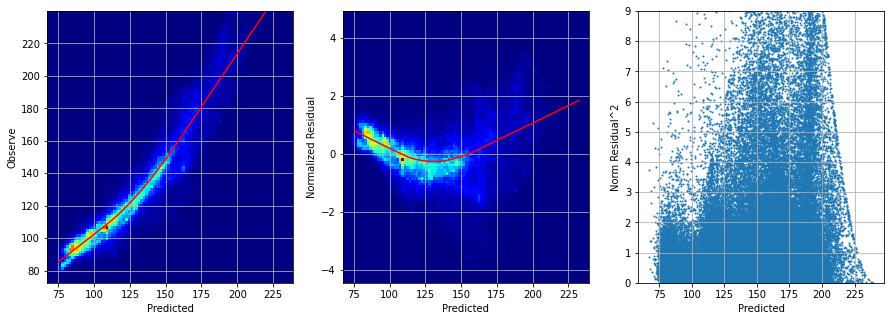

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax2.hist2d(pred, resid_p,bins=100, cmap='jet')
ax2.plot(pred_sort, resid_psm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Normalized Residual")
ax2.grid()

ax3.scatter(pred, resid_p2,s=1)
#a3.plot(pred_sort, resid_psm, color='red')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Norm Residual^2")
ax3.set_ylim((0,9))
ax3.grid()

ax1.hist2d(pred, obser,bins=100, cmap='jet')
ax1.plot(pred_sort, obser_sm, color='red')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observe")
ax1.grid()

plt.show()

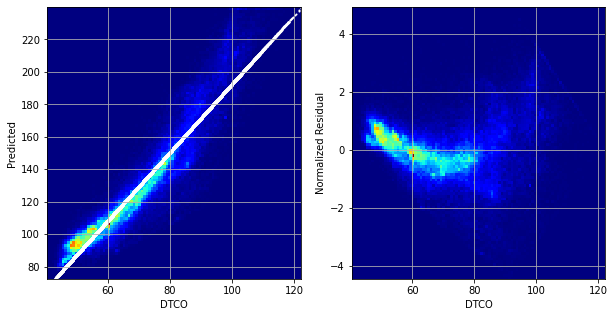

In [ ]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for i, col in enumerate(cols):
  ax1.hist2d(X_train, obser, bins=100, cmap='jet')
  ax1.scatter(dtco, pred, s=1, color='white')
  ax1.set_xlabel(col)
  ax1.set_ylabel("Predicted")
  ax1.grid()

  ax2.hist2d(X_train, resid_p,bins=100, cmap='jet')
  ax2.set_xlabel(col)
  ax2.set_ylabel("Normalized Residual")
  ax2.grid()
plt.show()

### Harvey-Collier multiplier test:
linear specification.

In [ ]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)


[('t value', 0.19218270482362235), ('p value', 0.847599380806912)]

###Rainbow test

In [ ]:
name = ['F statistic', 'p-value']
test = sms.linear_rainbow(results,frac=0.005)
lzip(name, test)

[('F statistic', 1.112509915190221), ('p-value', 0.028594120423504617)]

In [ ]:
rain_frac=[]
rain_pv=[]
for frac in np.arange(0.05,1,0.05):
  (_,pv)=sms.linear_rainbow(results, frac=frac)
  rain_frac.append(frac)
  rain_pv.append(pv)

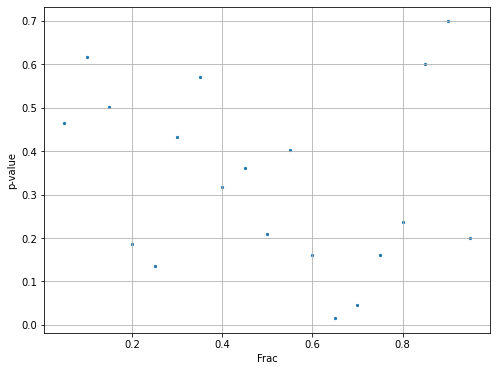

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.scatter(rain_frac, rain_pv, s=5)
ax.set_xlabel('Frac')
ax.set_ylabel("p-value")
ax.grid()

The p-values of Harvey-Collier multiplier test suggest that the null hypothesis is not rejected here. 

The rainbow test gives linearity violation at some portion of the data. This suggests some nonlinearity.

Residual plot also shows a slight parabolic trend (red). 

A squared term of **dtco** and other features will be added to the coming models.  


##Homoskedasticity tests


###White’s Two-Moment Specification Test: 
regression of the residual

In [ ]:
name = ['statistic', 'p-value','dof']
test = sms.diagnostic.spec_white(resid, model.exog)
lzip(name, test)

[('statistic', 12518.15073463967), ('p-value', 0.0), ('dof', 2)]

###Breush-Pagan test



In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18352.29047718477),
 ('p-value', 0.0),
 ('f-value', 21225.51542202143),
 ('f p-value', 0.0)]

###Goldfeld-Quandt test

The standard deviation of the distribution is proportional to X.

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, model.exog)
lzip(name, test)

[('F statistic', 0.9959738209663944), ('p-value', 0.7002610824466664)]

Null hypothesis of white test and BP test are rejected and heteroskedasticity assumed. Null hypothesis of GQ test is not rejected. std is not proportional to variables.

OLS is unbiased and efficient. It remains unbiased under heteroskedasticity, but efficiency is lost. [4]

## Normality of the residuals



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


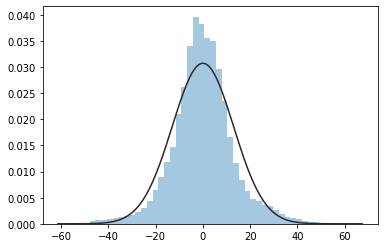

In [ ]:
sns.distplot(resid, kde=False, fit=norm)

###Jarque-Bera test:

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)


[('Jarque-Bera', 15248.854945775904),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.05655153914596329),
 ('Kurtosis', 4.639169490276407)]

Skewness is slightly positive, and a Kurtosis > 3 indicates higher probabilities at the mean and the tails than a normal distribution as the plot showing.

###Omni test:

In [ ]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 5045.260965687116), ('Two-tail probability', 0.0)]

Both tests reject the null hypothesis that the residual data are normally distributed.

###QQ-plot:


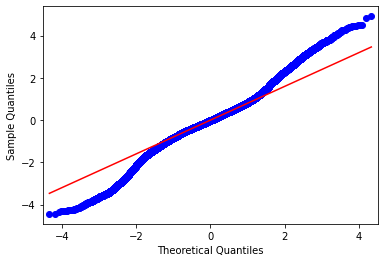

In [ ]:
fig = sm.qqplot(results.resid, fit=True, line='q')

plt.show()

The data have more extrem values than expected as normal distriubted data. 

The following may be considered.

Use GLMs for non-Guassian errors

Nonlinearly transform target variables

remove potential outliers

## Comments
Linearity is still hold under some tests. The plots however show a slight nonliear trend in the residuals. Homoscedasticity and normality are violated.

A simple linear model is not a good model here. More features and nonlinear term will be added to the new model. And multicollinearity will be therefore investigated as well as the outliers. 

##Test with another well log

In [ ]:
data2 = pd. read_csv('test01_log.csv')
data2.head()

,Depth,DTCO,DTSM
0,4677.0,85.6295,141.6536
1,4677.5,85.6336,142.7486
2,4678.0,86.7785,145.4792
3,4678.5,88.8323,150.3114
4,4679.0,90.1820,155.5185


In [ ]:
X1 = data2[['DTCO']].dropna(axis=0)
Y1 = data2.DTSM.values

In [ ]:
sm.add_constant(X_train).shape

(135562, 2)

In [ ]:
sm.add_constant(X1).shape

(14873, 2)

In [ ]:
pred1 = results.predict(sm.add_constant(X1))

print('MSE: %.2f' % mean_squared_error(Y1, pred1))
print('R^2 Score: %.2f' % r2_score(Y1, pred1))

MSE: 230.70
R^2 Score: -0.20


In [ ]:
# interactive

def trace_plot(st, intv):

  fig, (ax1, ax2) = plt.subplots(2,1,figsize=(25,8))

  ax1.plot(data2.Depth[st:st+intv], data2.DTSM[st:st+intv], color='blue', linewidth=1, label = 'real DTSM')
  ax1.plot(data2.Depth[st:st+intv], pred1[st:st+intv], color='red', linewidth=1, label='pred DTSM')
  ax1.grid()
  ax1.legend()
  
  ax1.set_ylabel("DTSM")

  ax2.plot(data2.Depth[st:st+intv], data2.DTCO[st:st+intv], color='green',linewidth=1,label = 'real DTCO')

  ax2.grid()
  ax2.legend()
  ax2.set_xlabel("Depth");
  ax2.set_ylabel("DTCO");


def trace_plot2(st, intv):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,10))

  ax1.plot(data2.DTSM[st:st+intv], data2.Depth[st:st+intv], color='blue', linewidth=1, label = 'real DTSM')
  ax1.plot(Y_pred2[st:st+intv], data2.Depth[st:st+intv], color='red', linewidth=1, label='pred DTSM')

  ax1.invert_yaxis()
  ax1.grid()
  ax1.legend()
  ax1.set_xlabel("DTSM")

  ax2.plot(data2.DTCO[st:st+intv], data2.Depth[st:st+intv], color='green',linewidth=1,label = 'real DTCO')

  ax2.invert_yaxis()
  ax2.grid()
  ax2.set_xlabel("DTCO")
  ax2.set_ylabel([])


In [ ]:
topmax=len(data2)-100
interactive(trace_plot, st=IntSlider(min=0, max=topmax, value=0, step=100, description="Top"),
                        intv=IntSlider(min=200, max=topmax, value=topmax, step=100, description="Inteval")
                        )

interactive(children=(IntSlider(value=0, description='Top', max=14773, step=100), IntSlider(value=14773, descr…

## Reference
[1] 
https://people.duke.edu/~rnau/testing.htm

[2]
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html

[3]
https://www.statsmodels.org/stable/diagnostic.html

[4]
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

[5] https://github.com/rorytboyle/hierarchical_regression/blob/master/regression_diagnostics.py

[6] https://statisticsbyjim.com/regression/gauss-markov-theorem-ols-blue/


